# **1. Pre-processing**

## **Load Packages**

In [ ]:
# File management
import os

# Data/numeric manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modelling
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

## **Load Data**

In [ ]:
# Create data directory
if not os.path.exists('/content/kaggle'):
    os.makedirs('/content/kaggle')
    
# Create output directory
if not os.path.exists('/content/output'):
    os.makedirs('/content/output')

# Download data from Kaggle API, unzip and place in data directory
os.environ['KAGGLE_USERNAME'] = "kallikrates"
os.environ['KAGGLE_KEY'] = "6ec6a025503be3d3b75961c4c2ac2748"
!kaggle datasets download -d kallikrates/nba-career-prediction-data
!unzip -q nba-career-prediction-data.zip -d /content/kaggle

  0% 0.00/367k [00:00<?, ?B/s]
100% 367k/367k [00:00<00:00, 54.2MB/s]


In [ ]:
#Create data objects
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

# **Experiment 1: XGBoost - Gridsearch of best scale_pos_weight value**

**Summary:**

This week I thought to move from XGBoost to other models. However, there was one parameter that I was not content with: scale_pos_weight. The recommended value was '8', as 80% of the training data is of the negative class. However, most of the articles I read about class imbalance presented some way of dealing with it and they were not all aligned.

Thinking about whether there may be another value for this data set (perhaps a different/better tuning for an unbalanced dataset), I came across this article https://machinelearningmastery.com/xgboost-for-imbalanced-classification/. This article states that the "heuristic for setting the scale_pos_weight is effective for many situations." This is the value used in the last set of experiments. As the negative class is about 80%, I set this value to 8. This article mentions that "it is possible that better performance can be achieved with a different class weighting, and this too will depend on the choice of performance metric used to evaluate the model." The article goes to show how this may be done applying grid search to a range of different class weightings, applying RepeatedStratifiedKFold to include the same percentage of target values in each fold I thought this may present an answer to my current performance slump. 


**Objective:**

Use Grid search to find the best parameter for scale_pos_weight in XG Boost model.


## **Define Data Objects**

In [ ]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

## **Define Models**

### **Model 0: Baseline**

In [ ]:
from sklearn.metrics import plot_roc_curve

The below model serves as a baseline model with default hyperparameter values.

In [ ]:
model0 = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc').fit(X_train, y_train)

roc_auc_score(y_val, model0.predict_proba(X_val)[:,1])

0.6867281887094496

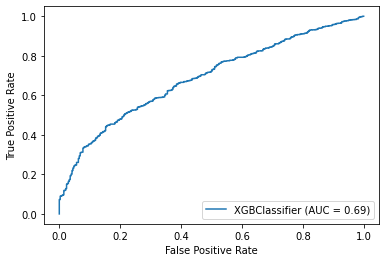

In [ ]:
model0_roc = plot_roc_curve(model0, X_val, y_val)

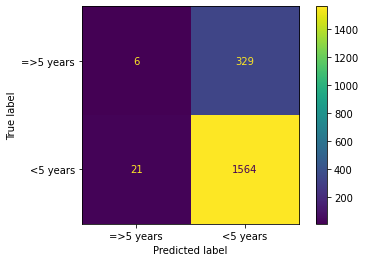

In [ ]:
plot_confusion_matrix(model0,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["=>5 years","<5 years"])

In [ ]:
model0.fit(X_train, y_train)
predictions = model0.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.22      0.02      0.03       335
           1       0.83      0.99      0.90      1585

    accuracy                           0.82      1920
   macro avg       0.52      0.50      0.47      1920
weighted avg       0.72      0.82      0.75      1920



### **Model 1: Grid Search scale_pos_weight**

This evaluates each positive class weighting using repeated k-fold cross-validation and reports the best configuration and the associated mean ROC AUC score. Using stratified fold cross validation to include the same percentage of target values in each fold.

In [ ]:
# grid search positive class weights with xgboost for imbalance classification
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# generate dataset
X, y = X_train, y_train

# define model
model = XGBClassifier()

# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)


# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.702416 using {'scale_pos_weight': 1000}
0.696945 (0.040145) with: {'scale_pos_weight': 1}
0.698167 (0.038971) with: {'scale_pos_weight': 10}
0.698911 (0.038540) with: {'scale_pos_weight': 25}
0.701846 (0.037866) with: {'scale_pos_weight': 50}
0.702203 (0.038235) with: {'scale_pos_weight': 75}
0.701595 (0.038869) with: {'scale_pos_weight': 99}
0.700904 (0.039697) with: {'scale_pos_weight': 100}
0.702416 (0.038916) with: {'scale_pos_weight': 1000}


### **Model 2: Run Model with best Grid Search scale_pos_weight (1000)**

Updating scale_pos_weight and also using stratified fold cross validation to include the same percentage of target values in each fold.

In [ ]:
# fit balanced xgboost on an imbalanced classification dataset
from sklearn.model_selection import cross_val_score

# generate dataset
X, y = X_train, y_train
# define model
model2 = XGBClassifier(scale_pos_weight=1000)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model2, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.70242


In [ ]:
model2 = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc',scale_pos_weight=1000).fit(X_train, y_train)

roc_auc_score(y_val, model2.predict_proba(X_val)[:,1])

0.6931409200056501

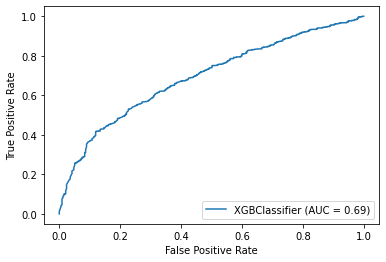

In [ ]:
model2_roc = plot_roc_curve(model2, X_val, y_val)

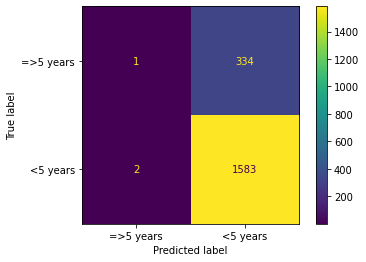

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model2,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["=>5 years","<5 years"])

In [ ]:
model2.fit(X_train, y_train)
predictions = model2.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       335
           1       0.83      1.00      0.90      1585

    accuracy                           0.82      1920
   macro avg       0.58      0.50      0.45      1920
weighted avg       0.74      0.82      0.75      1920



### **Model 3: Run Model with heuristically-based scale_pos_weight (8)**

As the class split is approximately 20:80, positive to negative class, the recommended value for an imbalanced dataset is 8. This will be compared to the value obtained from the Grid Search.

In [ ]:
# fit balanced xgboost on an imbalanced classification dataset
from sklearn.model_selection import cross_val_score

# generate dataset
X, y = X_train, y_train
# define model
model3 = XGBClassifier(scale_pos_weight=8)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model3, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.70133


In [ ]:
model3.fit(X_train, 
            y_train
           )

roc_auc_score(y_val, model3.predict_proba(X_val)[:,1])

0.6932106031357409

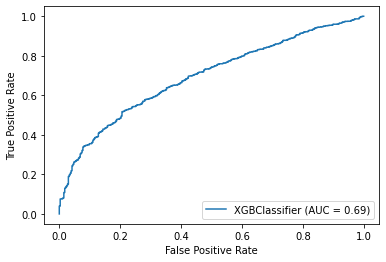

In [ ]:
model3_roc = plot_roc_curve(model3, X_val, y_val)

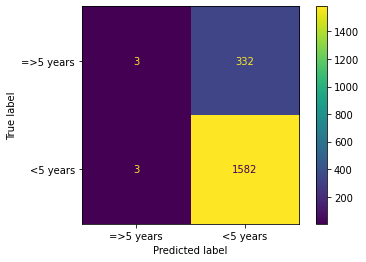

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model3,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["=>5 years","<5 years"])

In [ ]:
model3.fit(X_train, y_train)
predictions = model3.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       335
           1       0.83      1.00      0.90      1585

    accuracy                           0.83      1920
   macro avg       0.66      0.50      0.46      1920
weighted avg       0.77      0.83      0.75      1920



## **Conclusion:**

There is little difference between these model scores. When fitting train data, Model 2 (gridsearch model) is slightly higher than Model 3 (heuristically- sourced parameter). However, when using validation data, the difference is immaterial. 
**Conclusion:** looking at optimising this parameter to improve a model's predictive power is not effective. Also, this example showed that using StratifiedKFold as opposed to Gridsearch, made little difference to the outcome.

**Validation Scores**

In [ ]:
print(roc_auc_score(y_val, model0.predict_proba(X_val)[:,1]),
      roc_auc_score(y_val, model2.predict_proba(X_val)[:,1]),
      roc_auc_score(y_val, model3.predict_proba(X_val)[:,1]))

0.6867281887094496 0.6931409200056501 0.6932106031357409


# **Experiment 2: Non-XGBoost Model Comparisons**

**Summary:**

During the last few weeks, and in Experiment 1, I have worked with XGBoost models, thinking they may be the best for binary classification. I based this assumption on past experience and some reading, especially about winning Kaggle competitions. This week I wanted to move away from this to something else. However, it was dificult to know what as 1. many opinions vary on the subject 2. this data set is unique and thus, approaches which have produced good results working with other data sets will not necessarily work on this. As such, I thought to  compare these models side by side.

**Objective:**

Compare Non-XGBoost models, especially for Accuracy and ROC AUC.


##**Import Packages**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV

## **Define Data Objects**

In [ ]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

## **Define Models**

### **Logistic Regression**

In [ ]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

### **Decision Tree**

In [ ]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

### **SVM**

In [ ]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

### **Linear Discriminant Analysis**

In [ ]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

### **Quadratic Discriminant Analysis**

In [ ]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

### **Random Forest**

In [ ]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

### **K-Neighbors**

In [ ]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

### **Gaussian Naive Bayes**

In [ ]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=20)
sorted(scores.keys())
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

### **Model Comparison**

In [ ]:
models_compare = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
5,Random Forest,0.700315,0.026402,0.846528,0.702262,0.533696,0.794738,0.687638
3,Linear Discriminant Analysis,0.016826,0.007836,0.845486,0.667750,0.521370,0.787666,0.692667
2,Support Vector Machine,1.838469,0.023062,0.844792,0.422396,0.500000,0.773720,0.597506
0,Logistic Regression,0.038426,0.008252,0.843056,0.510242,0.502645,0.775375,0.697704
6,K-Nearest Neighbors,0.007037,0.028137,0.822917,0.581327,0.532849,0.786344,0.582184
4,Quadratic Discriminant Analysis,0.007251,0.007691,0.775694,0.587542,0.590320,0.779260,0.655692
1,Decision Tree,0.041543,0.005535,0.757292,0.556439,0.562317,0.762298,0.562317
7,Bayes,0.003104,0.005663,0.600694,0.563796,0.618643,0.654710,0.676532


## **Conclusion:**

It would seem that Logistic Regression, Linear Discriminant Analysis and Random Forrest will produce the best result. However, given that Model 2 in Experiment 1 had a ROC AUC of 0.70242 and accuracy of 0.82, this is not a very strong argument for the use of one of these models.

# **Experiment 3: Optimised XGB Versus Optimised Light GBM**

**Summary:**

In previous experiments, I have trained and run XGBoost models, tweaking the data (dimensionality reduction/feature engineering), and the hyperparameters to best suit the data. The best result has been an AUC of 0.726, which translated to 0.685 when submitted in Kaggle. 

This week, I have also tried to compare all popular binary classification models to the best of XGBoost, to no success.

This experiment will be to compare One more model: LightGBM, with a set of optimised hyperparameters for both it and a comparative XGBoost model. This will be done by defining a class that iterates through predictions assessing them by a specified loss function (mean ROC AUC). Last week I tried this using hyperopt, with almost neutral value. 

**Objective:**

Attempt to beat the highest AUC of 0.726, with this optimised LightGBM or XGBoost model.


## **Import Packages**

In [ ]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

## **Define Data Objects**

In [ ]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

## **Define Search Space and Loss Functions**

Create a dictionary with parameters and a loss function for use in calculation class. 

In [ ]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.9)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.mean(roc_auc_score(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.mean(roc_auc_score(y, pred))

## **Define Calculation Class**

In [ ]:
class HPOpt(object):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.x_train = X_train
        self.x_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

## **Caclulate Optimal Hyperparameters**

In [ ]:
obj = HPOpt(X_train, X_test, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [00:10<00:00,  9.82it/s, best loss: 0.5011531975280906]


In [ ]:
xgb_opt

({'colsample_bytree': 1,
  'learning_rate': 0,
  'max_depth': 10,
  'min_child_weight': 6,
  'subsample': 0.8373798269697786},
 <hyperopt.base.Trials at 0x7f45bb82a2b0>)

In [ ]:
lgb_opt

({'colsample_bytree': 4,
  'learning_rate': 1,
  'max_depth': 5,
  'min_child_weight': 6,
  'subsample': 0.832057919013642},
 <hyperopt.base.Trials at 0x7f45bb5c3a90>)

## **Fit Models With Optimal Hyperparameters**

### **XG Boost**

Learning rate looks rounded. Using small figure close to 0.

In [ ]:
xgb_clf = XGBClassifier(learning_rate=0.0000001,
                        eval_metric='auc',
                        colsample_bytree=1,
                        max_depth=10,
                        min_child_weight=6,
                        subsample=0.8373798269697786,
                      ).fit(X_train, y_train)

roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])

0.7156990545714011

### **Light GBM**

In [ ]:
lgb_model = lgb.LGBMClassifier(colsample_bytree=1.0,
                               learning_rate=1,
                               max_depth=5,
                               min_child_weight=6,
                               subsample=0.832057919013642,
                                ).fit(X_train, y_train)
roc_auc_score(y_val, lgb_model.predict_proba(X_val)[:,1])

0.612621265968687

## **Conclusion**

Once again, the XGBoost model outperforms a model that arguably could  do better than it in this scenario. These parameters are quire diferent to those obtained by hyperopt, as they use different algorithms to optimise. However, they are quite close (this week=0.715, hyperopt=0.716).